# **Imports and setup**

In [8]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm
from sklearn.preprocessing import StandardScaler
#from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

from Lambert import Gaussianize
from preprocess import *
from model import * 

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [2]:
# Get the data for SP500 from May 2009 till Dec 2018 (as in the original paper)
sp500 = yf.download('^GSPC', start='2009-05-01', end='2018-12-31')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


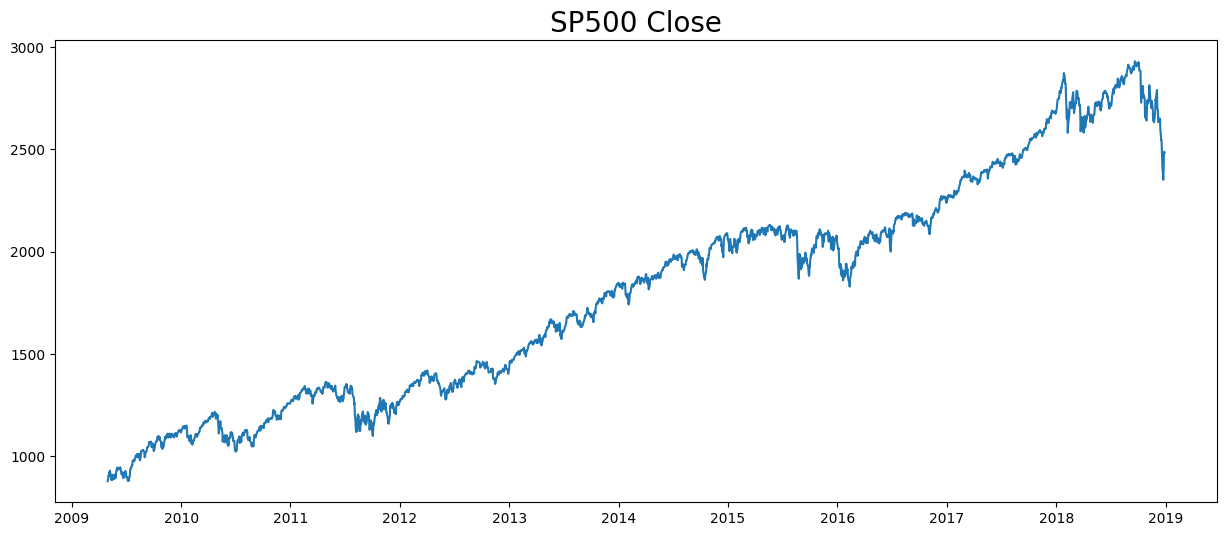

In [3]:
fig = plt.figure(figsize=(15,6))
plt.title('SP500 Close', fontsize=20)
plt.plot(sp500)
plt.show()

## **Preprocessing**

In [4]:
sp500log = np.log(sp500 / sp500.shift(1))[1:].values

In [5]:
normalise_1 = StandardScaler()
log_std_1 = normalise_1.fit_transform(sp500log)

lambertw = Gaussianize()
log_gaussianized = lambertw.fit_transform(log_std_1)

normalise_2 = StandardScaler()
log_returns_preprocessed = normalise_2.fit_transform(log_gaussianized)

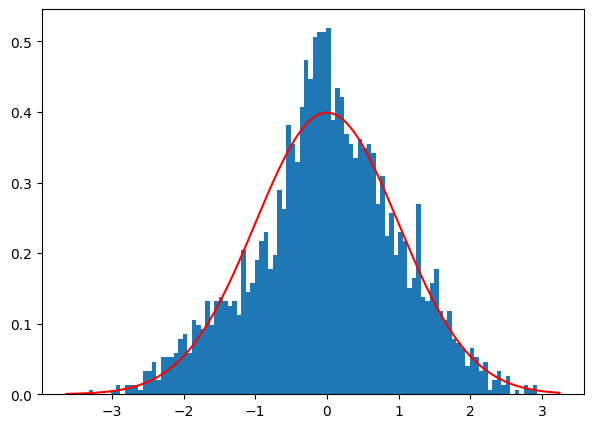

In [8]:
plt.hist(log_returns_preprocessed, bins=100, density=True)
x_axis = np.linspace(plt.xlim(), 2, num=1000)
mu, std = np.mean(log_returns_preprocessed), np.std(log_returns_preprocessed)
plt.plot(x_axis, norm.pdf(x_axis, mu, std), 'r', label='Normal PDF')
plt.show()

In [9]:
print("(127,1)")
log_returns_preprocessed[0:127].reshape(-1,127).shape

(127,1)


(1, 127)

In [10]:
# Dataset
class Loader(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __getitem__(self, idx):
        sample = self.data[idx:idx+self.window_size]
        return torch.tensor(sample).reshape(-1,self.window_size).float()

    def __len__(self):
        return len(self.data) - self.window_size

In [11]:
receptive_field_size = 127  # p. 17
data_size = log_returns_preprocessed.shape[0]

print(data_size)

2432


# **Models for GAN**

# **Prepare and train GAN**

In [13]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 1e-2

In [14]:
import torch.optim as optim
from tqdm import tqdm

# Dataset et loader
dataset = Loader(log_returns_preprocessed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

generator = Generator().to(device)
discriminator = Discriminator(seq_len).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

t = tqdm(range(num_epochs))
for epoch in t:
    for idx, data in enumerate(dataloader):

        discriminator.zero_grad()
        real = data.to(device)
        noise = torch.randn(real.size(0), nz, real.size(2), device=device)
        fake = generator(noise).detach()
        disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        disc_loss.backward()
        disc_optimizer.step()

        for dp in discriminator.parameters():
            dp.data.clamp_(-clip, clip)

        if idx % 5 == 0:
            generator.zero_grad()
            gen_loss = -torch.mean(discriminator(generator(noise)))
            gen_loss.backward()
            gen_optimizer.step()


    t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Discriminator Loss: 0.00000000 Generator Loss: -0.50059414: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [ ]:
torch.save(generator, 'generator.pth')
#generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')

# Generation

In [51]:
generator.eval()
noise = torch.randn(80,3,2500).to(device)
y = generator(noise).cpu().detach().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = normalise_2.inverse_transform(y)
y = np.array([lambertw.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = normalise_1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * sp500log.max()) & (y.min(axis=1) >= 2 * sp500log.min())]
y -= y.mean()
len(y)

49

## Results and visualizing stylized facts

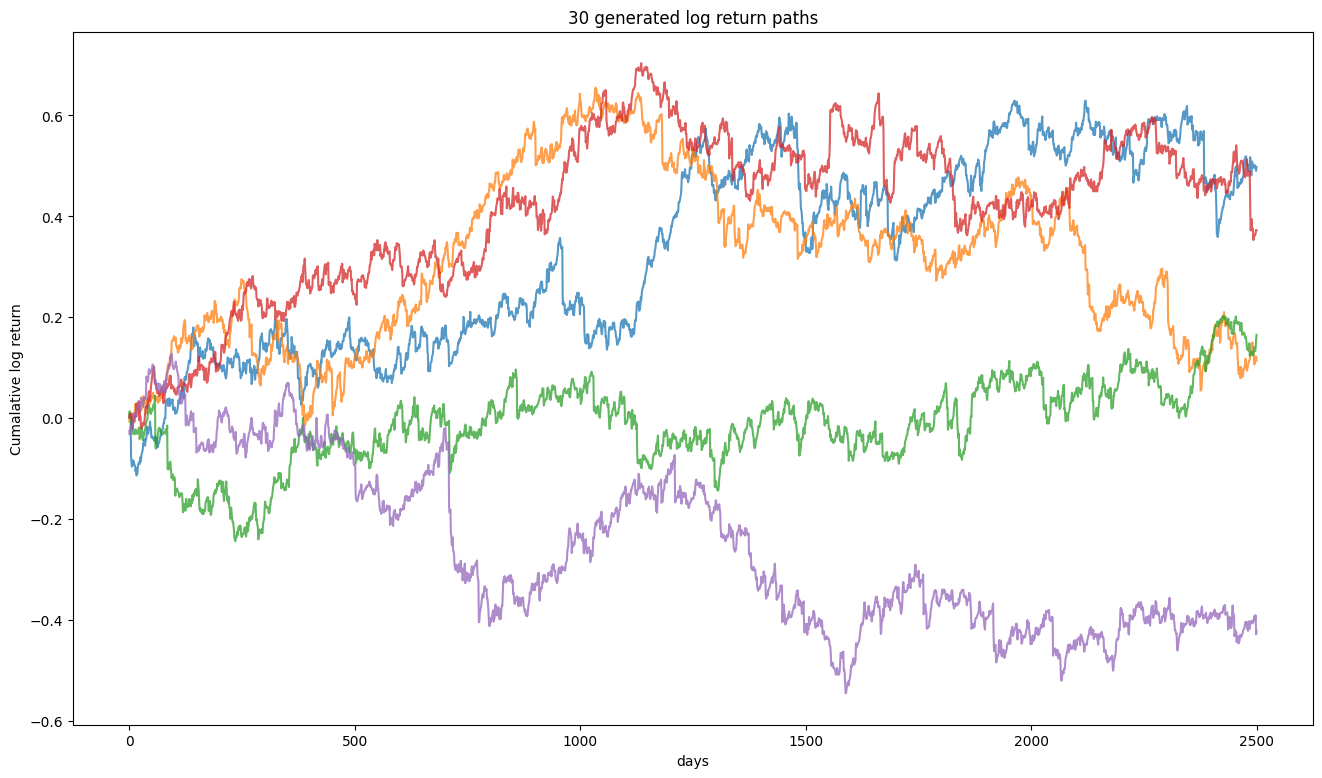

In [53]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:5], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

NameError: name 'y' is not defined

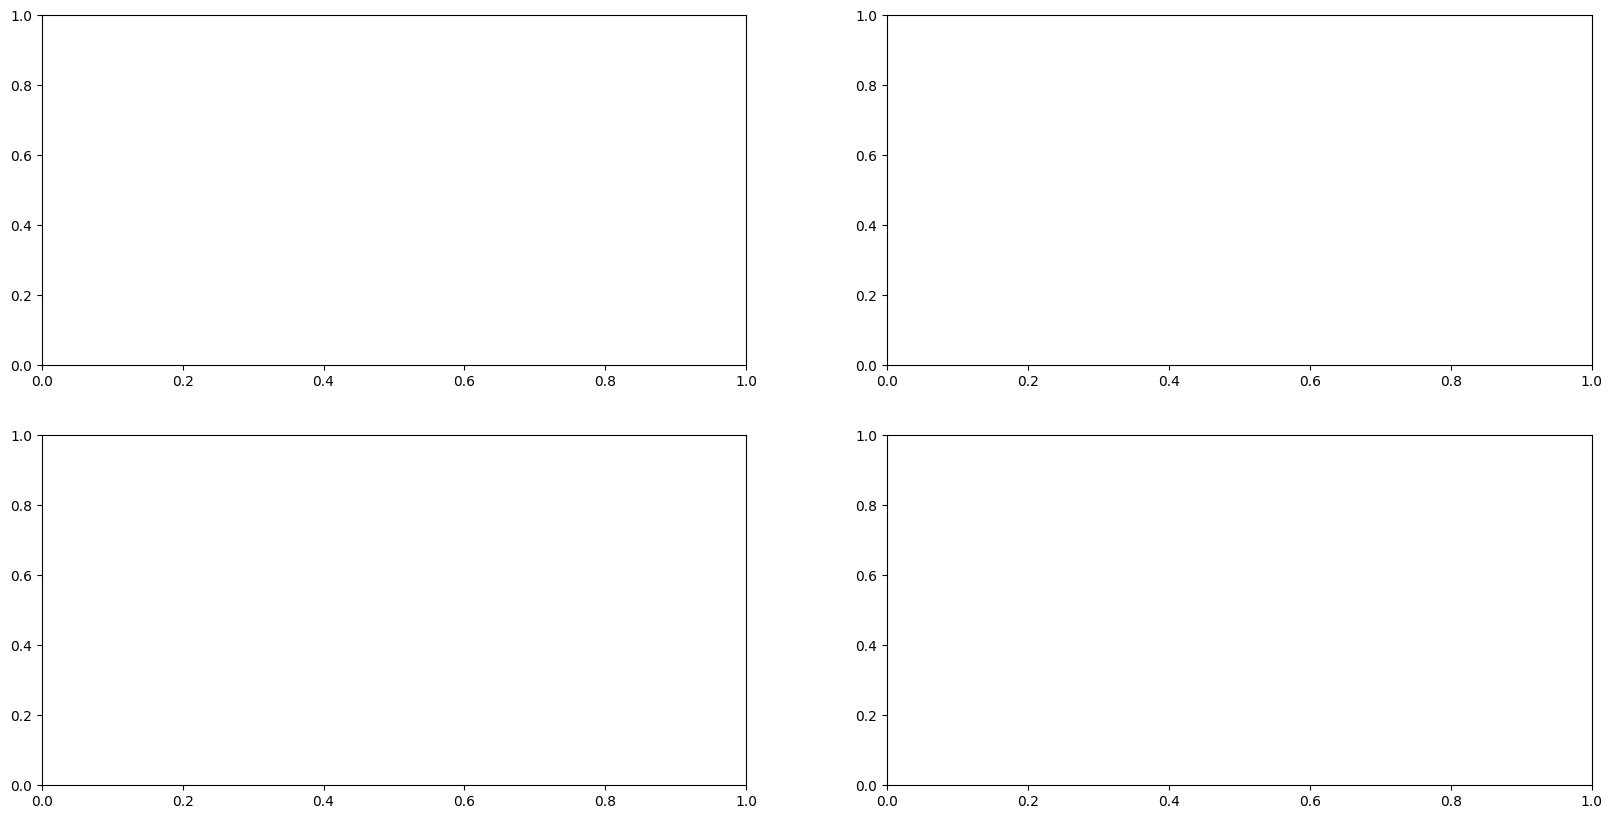

In [7]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(sp500log, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

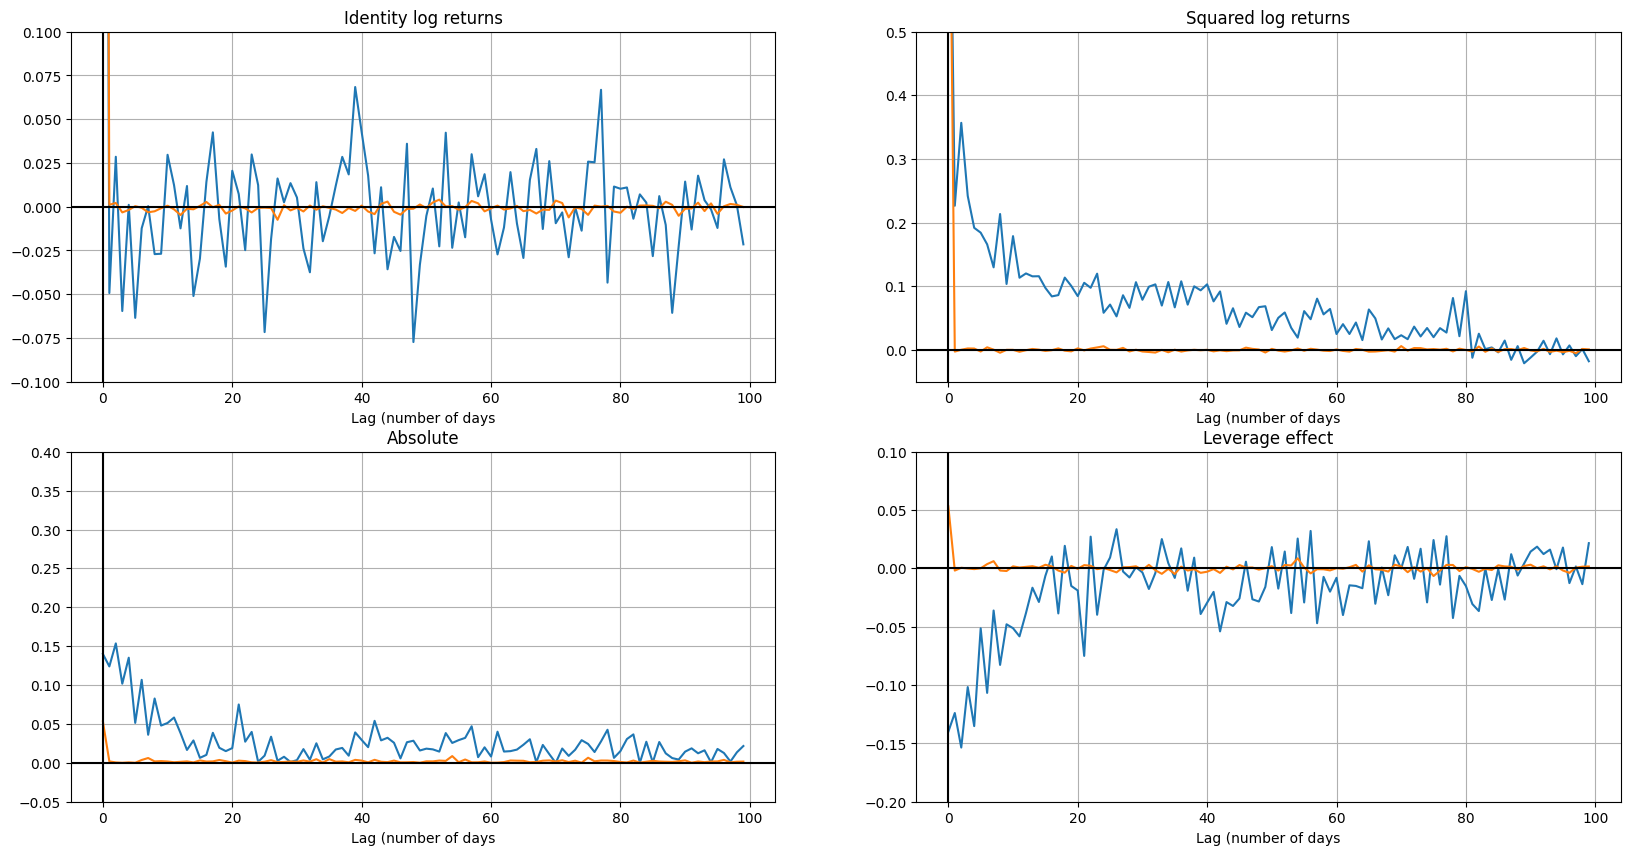

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(sp500log, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(sp500log**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(sp500log, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(sp500log, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

# **C-SVNN**

In [15]:
normalise_1 = StandardScaler()
log_std_1 = normalise_1.fit_transform(sp500log)

lambertw = Gaussianize()
log_gaussianized = lambertw.fit_transform(log_std_1)

normalise_2 = StandardScaler()
log_returns_preprocessed = normalise_2.fit_transform(log_gaussianized)

In [ ]:
def generate_returns_from_svnn(sigma, mu, epsilon):
    """
    Combine sigma, mu, epsilon pour générer les returns simulés.

    Args:
        sigma (torch.Tensor): (batch_size, seq_len-1)
        mu (torch.Tensor): (batch_size, seq_len-1)
        epsilon (torch.Tensor): (batch_size, seq_len-1)

    Returns:
        returns (torch.Tensor): (batch_size, seq_len-1)
    """
    return sigma * epsilon + mu


# **Prepare and train GAN**

In [37]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 1e-2

In [ ]:
generator = CSVNNGenerator().to(device)
discriminator = Discriminator(seq_len=seq_len-1).to(device)  # ATTENTION: seq_len-1 car on travaille sur 126 !

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    for i, real_samples in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        # --- Génération du bruit
        noise = torch.randn(batch_size, nz, seq_len).to(device)

        # === Train Discriminator ===
        discriminator.zero_grad()

        # Générer fake returns
        sigma, mu, epsilon = generator(noise)  # (batch_size, seq_len-1) chacun
        fake_returns = generate_returns_from_svnn(sigma, mu, epsilon)  # (batch_size, seq_len-1)

        # Préparer vrais returns
        real_returns = real_samples.squeeze(1)[:, :-1]  # Enlever le dernier pour matcher fake (batch_size, seq_len-1)

        # Reshape pour le discriminateur : ajouter dimension channel=1
        real_input = real_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)
        fake_input = fake_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)

        # Calcul loss Discriminateur
        loss_D = -torch.mean(discriminator(real_input)) + torch.mean(discriminator(fake_input))
        loss_D.backward()
        optimizer_D.step()

        # Clipping des poids (WGAN)
        for p in discriminator.parameters():
            p.data.clamp_(-clip, clip)

        # === Train Generator ===
        if i % 5 == 0:
            optimizer_G.zero_grad()

            sigma, mu, epsilon = generator(noise)
            fake_returns = generate_returns_from_svnn(sigma, mu, epsilon)
            fake_input = fake_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)

            loss_G = -torch.mean(discriminator(fake_input))
            loss_G.backward()
            optimizer_G.step()

    pbar.set_description(f"Epoch {epoch}: D Loss {loss_D.item():.4f}, G Loss {loss_G.item():.4f}")


Epoch 99: D Loss -0.0001, G Loss -0.5005: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


In [ ]:
#torch.save(generator, 'generator.pth')
#generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')

# Generation

In [45]:
# Mode evaluation
generator.eval()

# Bruit (80 échantillons, 3 features, 2500 pas de temps)
noise = torch.randn(80, 3, 2500).to(device)

# Générer sigma, mu, epsilon
with torch.no_grad():
    sigma, mu, epsilon = generator(noise)  # chacun (80, 2499) car 2500-1

# Simuler les returns
y = sigma * epsilon + mu  # (80, 2499)

# Normaliser les données (z-score)
y = (y - y.mean(dim=1, keepdim=True)) / y.std(dim=1, keepdim=True)  # normaliser chaque série

# Remettre dans l'échelle initiale
y = y.cpu().numpy()
y = normalise_2.inverse_transform(y)
y = np.array([lambertw.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = normalise_1.inverse_transform(y)

# Filtrer les séries pour éviter des extrêmes absurdes
y = y[(y.max(axis=1) <= 2 * sp500log.max()) & (y.min(axis=1) >= 2 * sp500log.min())]

# Recentrer
y -= y.mean()

print("Nombre de trajectoires retenues :", len(y))

Nombre de trajectoires retenues : 36


## Results and visualizing stylized facts

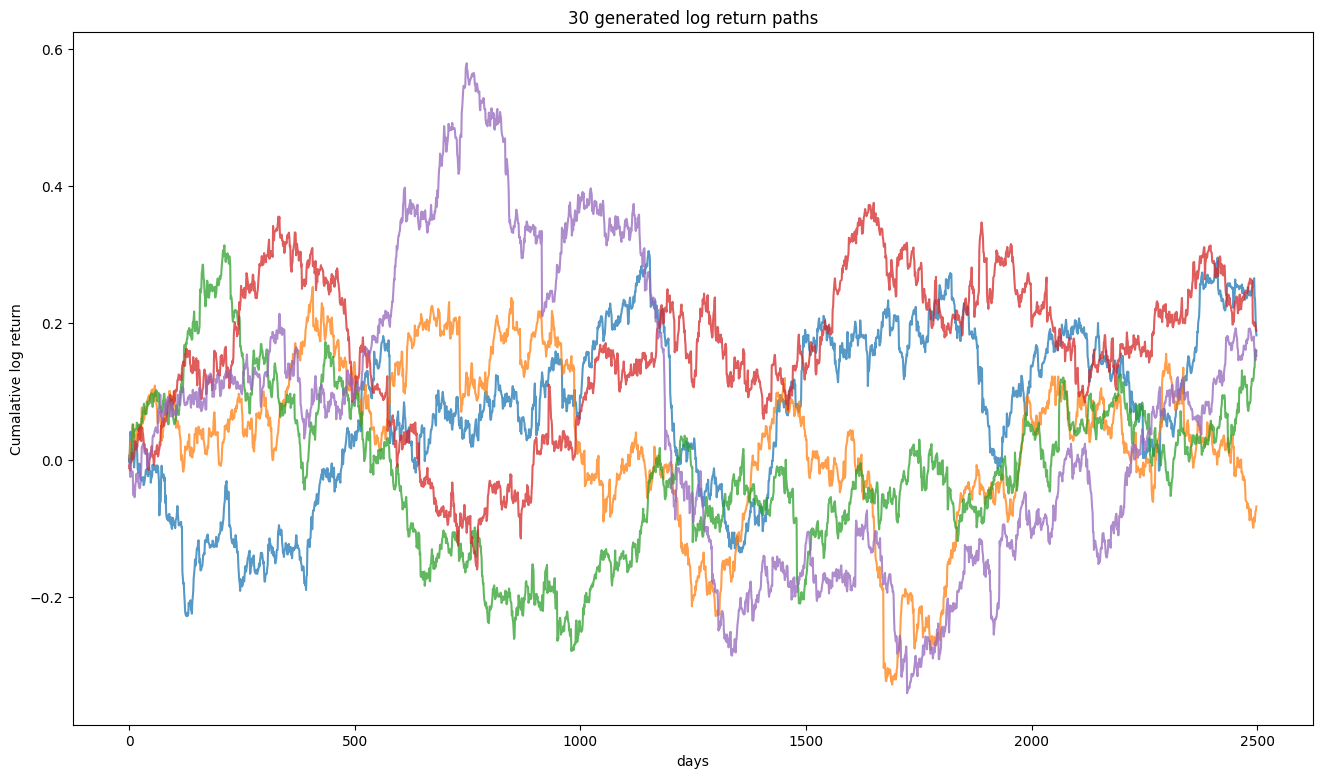

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:5], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

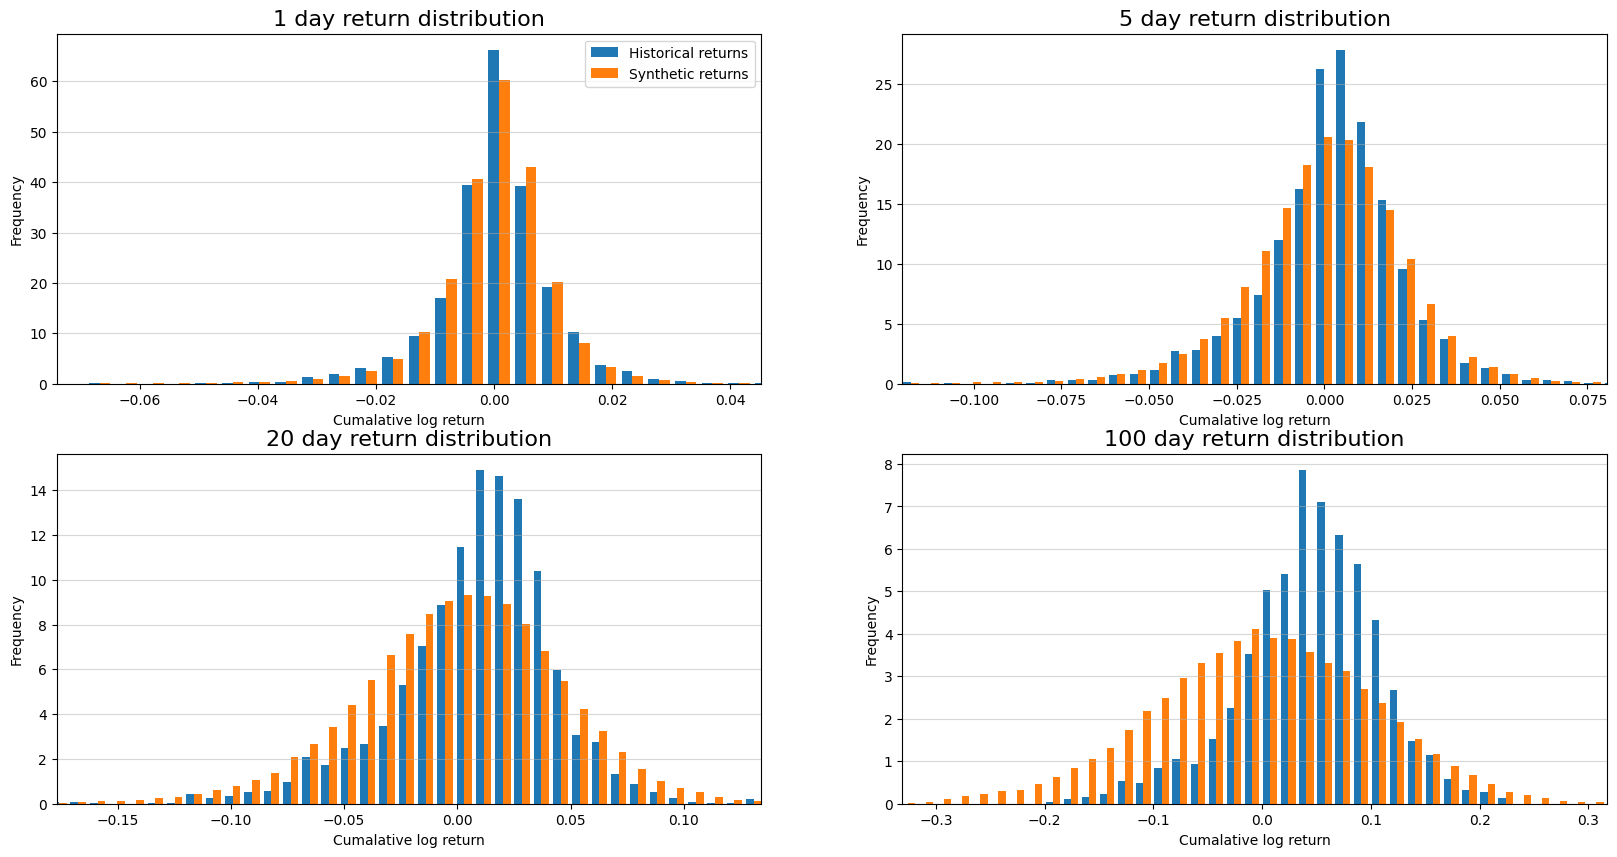

In [52]:
n_bins = 100
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(sp500log, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

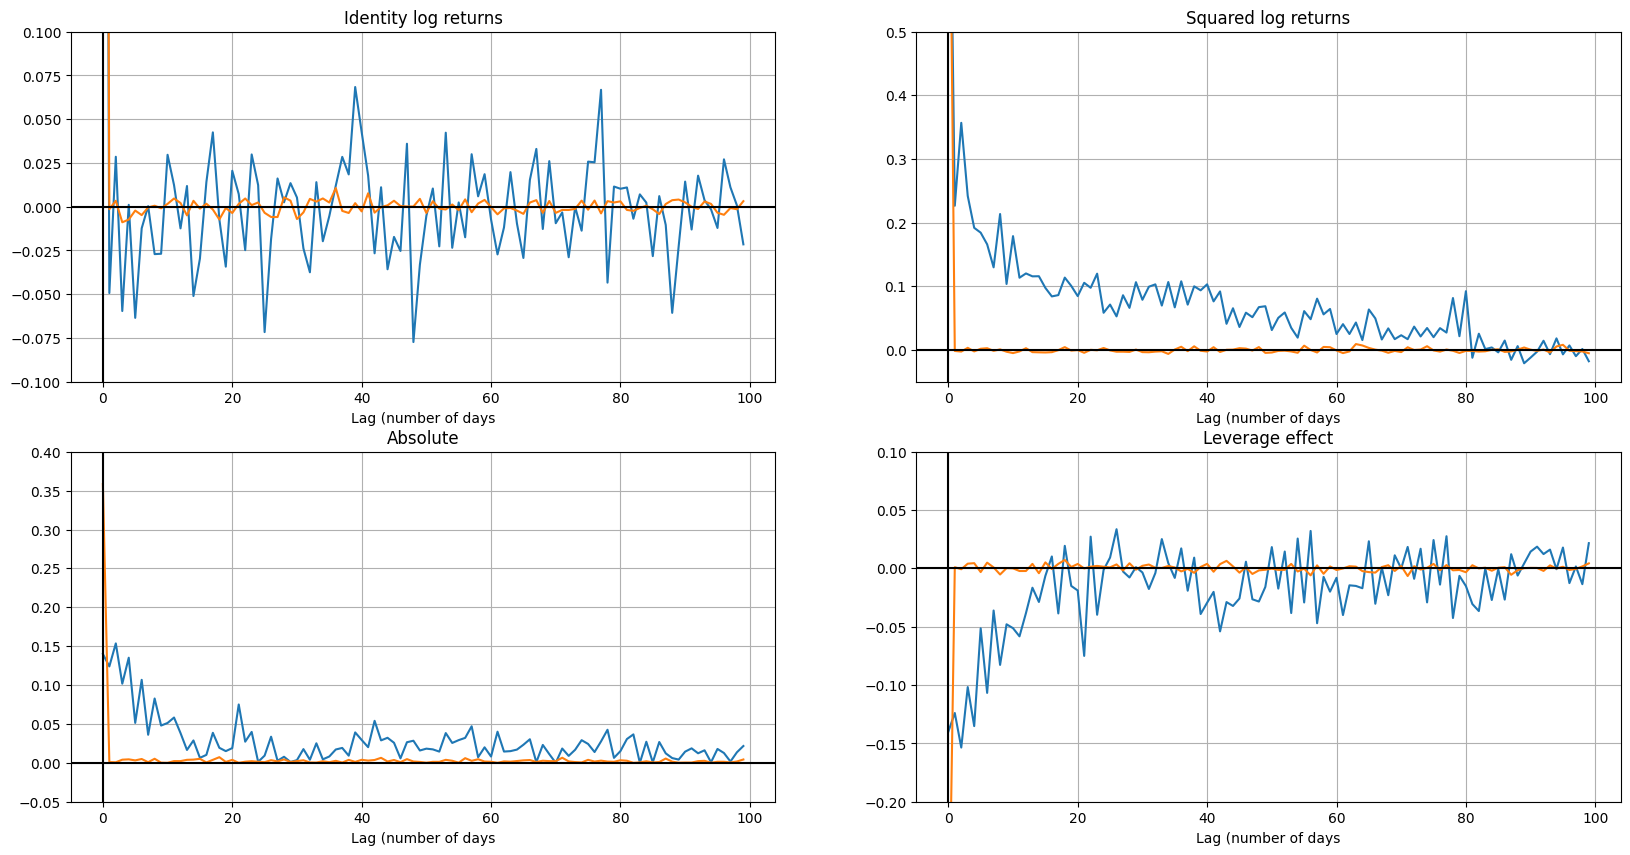

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(sp500log, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(sp500log**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(sp500log, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(sp500log, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')